# Compare the CIGALE results of EMU and non-EMU sources

In [ ]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [41]:
import numpy as np
import pandas as pd
import math


# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
# Use the Planck 2020/2018 cosmology
from astropy.cosmology import Planck18 as cosmo

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Seaborn
import seaborn as sns

## Import results files from EMU and non-EMU sources and select objects with x²_red < 5

In [59]:
emu_sources = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/emu_data/out_withAGN/results.txt', sep='\s+')
nonemu_sources = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/out/results.txt', sep='\s+')
nonemu_prototypes = pd.read_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/prototypes/results.txt', sep='\s+')

In [89]:
emu_sources['bayes.sfh.sfr'].describe()

count    3530.000000
mean       71.238355
std       305.070267
min         0.060517
25%         4.846415
50%        19.131346
75%        62.284044
max      9764.363266
Name: bayes.sfh.sfr, dtype: float64

Select EMU and non-EMU sources with a x²_red less than 5 , to analyse sources with a good fitting.

In [67]:
best_matches_emu = emu_sources['best.reduced_chi_square'] <= 5.0
emu_sources_best = emu_sources[best_matches_emu]
print(f'Number of emu objects with x²_red <= 5: {len(emu_sources_best)}')
emu_sources_best['bayes.sfh.sfr_permass'] =  emu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star']


best_matches_nonemu = nonemu_sources['best.reduced_chi_square'] <= 5.0
nonemu_sources_best = nonemu_sources[best_matches_nonemu]
print(f'Number of non-emu objects with x²_red <= 5: {len(nonemu_sources_best)}')
nonemu_sources_best['bayes.sfh.sfr_permass'] =  nonemu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star']


best_matches_nonemu_prots = nonemu_prototypes['best.reduced_chi_square'] <= 5.0
nonemu_prototypes_best = nonemu_prototypes[best_matches_nonemu_prots]
print(f'Number of non-emu prototypes with x²_red <= 5: {len(nonemu_prototypes_best)}')

Number of emu objects with x²_red <= 5: 3497
Number of non-emu objects with x²_red <= 5: 6243
Number of non-emu prototypes with x²_red <= 5: 2474


/tmp/ipykernel_6000/2278715652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_sources_best['bayes.sfh.sfr_permass'] =  emu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star']
/tmp/ipykernel_6000/2278715652.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonemu_sources_best['bayes.sfh.sfr_permass'] =  nonemu_sources_best['bayes.sfh.sfr']/emu_sources_best['bayes.stellar.m_star']


## Values

In [85]:
def simple_avg_and_error(values, errors):
    values = np.asarray(values)
    
    avg = np.median(values)
    avg_error = np.median(errors)
    
    return avg, avg_error

In [86]:
# Non-EMU
avg_stellarmass, err_stellarmass = simple_avg_and_error(nonemu_sources_best['bayes.stellar.m_star'], nonemu_sources_best['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(avg_stellarmass):.4f} ± {np.log10(err_stellarmass):.4f}')

avg_sfr, err_sfr = simple_avg_and_error(nonemu_sources_best['bayes.sfh.sfr'], nonemu_sources_best['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(avg_sfr):.4f} ± {np.log10(err_sfr):.4f}')

avg_metallicity, err_metallicity = simple_avg_and_error(nonemu_sources_best['bayes.stellar.metallicity'], nonemu_sources_best['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{avg_metallicity:.4f} ± {err_metallicity:.4f}')

avg_age, err_age = simple_avg_and_error(nonemu_sources_best['bayes.sfh.age'], nonemu_sources_best['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(avg_age):.4f} ± {np.log10(err_age):.4f}')

avg_Av_BC, err_Av_BC = simple_avg_and_error(nonemu_sources_best['bayes.attenuation.Av_BC'], nonemu_sources_best['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{avg_Av_BC:.4f} ± {err_Av_BC:.4f}')

avg_AGN, err_AGN = simple_avg_and_error(nonemu_sources_best['bayes.agn.fracAGN'], nonemu_sources_best['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{avg_AGN:.4f} ± {err_AGN:.4f}')

Stellar Mass: 10.6316 ± 10.4409
Star Formation Rate: 0.9423 ± 1.4317
Metallicity: 0.0146 ± 0.0118
Age: 3.6320 ± 3.3421
Av_BC: 0.3927 ± 0.2965
AGN Fraction: 0.2329 ± 0.3004


In [87]:
# EMU
avg_stellarmass, err_stellarmass = simple_avg_and_error(emu_sources_best['bayes.stellar.m_star'], emu_sources_best['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(avg_stellarmass):.4f} ± {np.log10(err_stellarmass):.4f}')

avg_sfr, err_sfr = simple_avg_and_error(emu_sources_best['bayes.sfh.sfr'], emu_sources_best['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(avg_sfr):.4f} ± {np.log10(err_sfr):.4f}')

avg_metallicity, err_metallicity = simple_avg_and_error(emu_sources_best['bayes.stellar.metallicity'], emu_sources_best['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{avg_metallicity:.4f} ± {err_metallicity:.4f}')

avg_age, err_age = simple_avg_and_error(emu_sources_best['bayes.sfh.age'], emu_sources_best['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(avg_age):.4f} ± {np.log10(err_age):.4f}')

avg_Av_BC, err_Av_BC = simple_avg_and_error(emu_sources_best['bayes.attenuation.Av_BC'], emu_sources_best['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{avg_Av_BC:.4f} ± {err_Av_BC:.4f}')

avg_AGN, err_AGN = simple_avg_and_error(emu_sources_best['bayes.agn.fracAGN'], emu_sources_best['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{avg_AGN:.4f} ± {err_AGN:.4f}')

Stellar Mass: 10.9504 ± 10.3786
Star Formation Rate: 1.2864 ± 1.4287
Metallicity: 0.0198 ± 0.0117
Age: 3.5574 ± 3.2493
Av_BC: 0.4979 ± 0.2160
AGN Fraction: 0.1575 ± 0.2462


## Compare EMU and non-EMU sources

### Histogram of EMU and non-EMU sources

In [53]:
def plot_log_hist_percent_2rows_sns(
    df1, df2, columns, x_labels, legend_positions, 
    labels, titles, figsize=(15, 8), bins=50
):
    """
    Plot histograms with y-axis as percentage of total sources for two DataFrames in 2 rows.
    Includes vertical lines for mean values. Uses log scaling on x-axis where appropriate.

    Parameters:
    - df1, df2: pandas DataFrames
    - columns: list of column names to plot (must exist in both)
    - x_labels: list of x-axis labels (same length as columns)
    - legend_positions: list of legend positions per subplot
    - labels: tuple of legend labels for df1 and df2
    - figsize: tuple for figure size
    - bins: number of bins or sequence of bin edges
    """
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]
        
        data1 = df1[col].dropna()
        data2 = df2[col].dropna()

        if 'bayes.agn.fracAGN' in col:
            # Linear scale
            ax.hist(
                data1,
                bins=bins,
                weights=np.ones_like(data1) * 100 / len(data1),
                alpha=0.5,
                label=labels[0],
                color='blue'
            )
            ax.hist(
                data2,
                bins=bins,
                weights=np.ones_like(data2) * 100 / len(data2),
                alpha=0.5,
                label=labels[1],
                color='red'
            )
            # Means
            ax.axvline(data1.median(), color='blue', linestyle='dashed', linewidth=1.5)
            ax.axvline(data2.median(), color='red', linestyle='dashed', linewidth=1.5)

            ax.set_xlabel(x_labels[i])

        else:
            # Log scale
            data1 = data1[data1 > 0]
            data2 = data2[data2 > 0]
            min_val = min(data1.min(), data2.min())
            max_val = max(data1.max(), data2.max())
            log_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

            ax.hist(
                data1,
                bins=log_bins,
                weights=np.ones_like(data1) * 100 / len(data1),
                alpha=0.5,
                label=labels[0],
                color='blue'
            )
            ax.hist(
                data2,
                bins=log_bins,
                weights=np.ones_like(data2) * 100 / len(data2),
                alpha=0.5,
                label=labels[1],
                color='red'
            )
            ax.set_xscale('log')
            ax.set_xlabel(x_labels[i])

            # Means (log scale plots)
            ax.axvline(data1.median(), color='blue', linestyle='dashed', linewidth=1.5)
            ax.axvline(data2.median(), color='red', linestyle='dashed', linewidth=1.5)

        ax.set_title(titles[i])
        ax.set_ylabel('Percentage of Sources [%]')
        ax.legend(loc=legend_positions[i])

    # Hide unused subplots
    for j in range(n, nrows * ncols):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

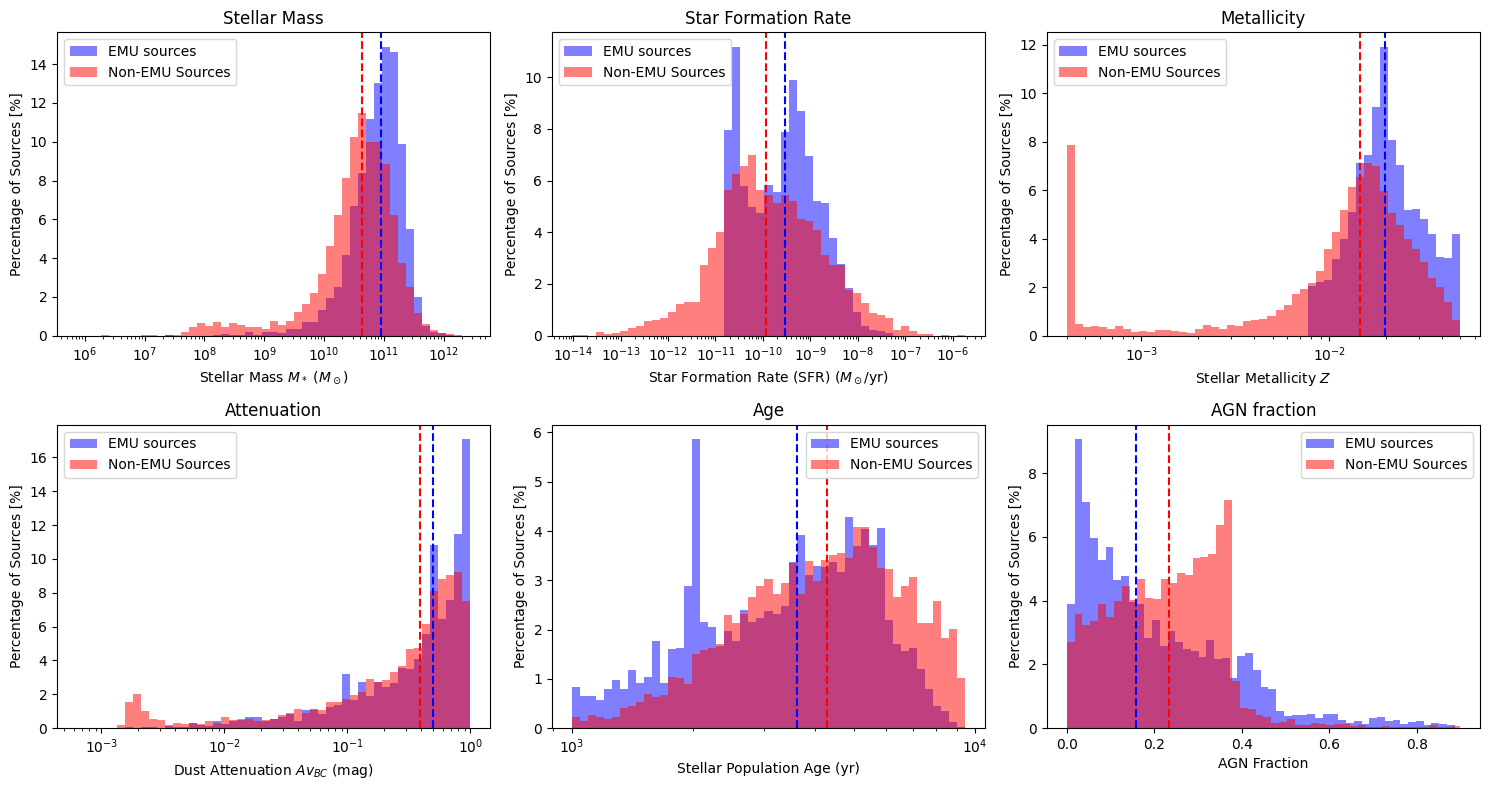

In [72]:
plot_log_hist_percent_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr_permass', 'bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $Av_{BC}$ (mag)",
        r"Stellar Population Age (yr)",
        r"AGN Fraction",
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions= ['upper left', 'upper left','upper left','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction']
)

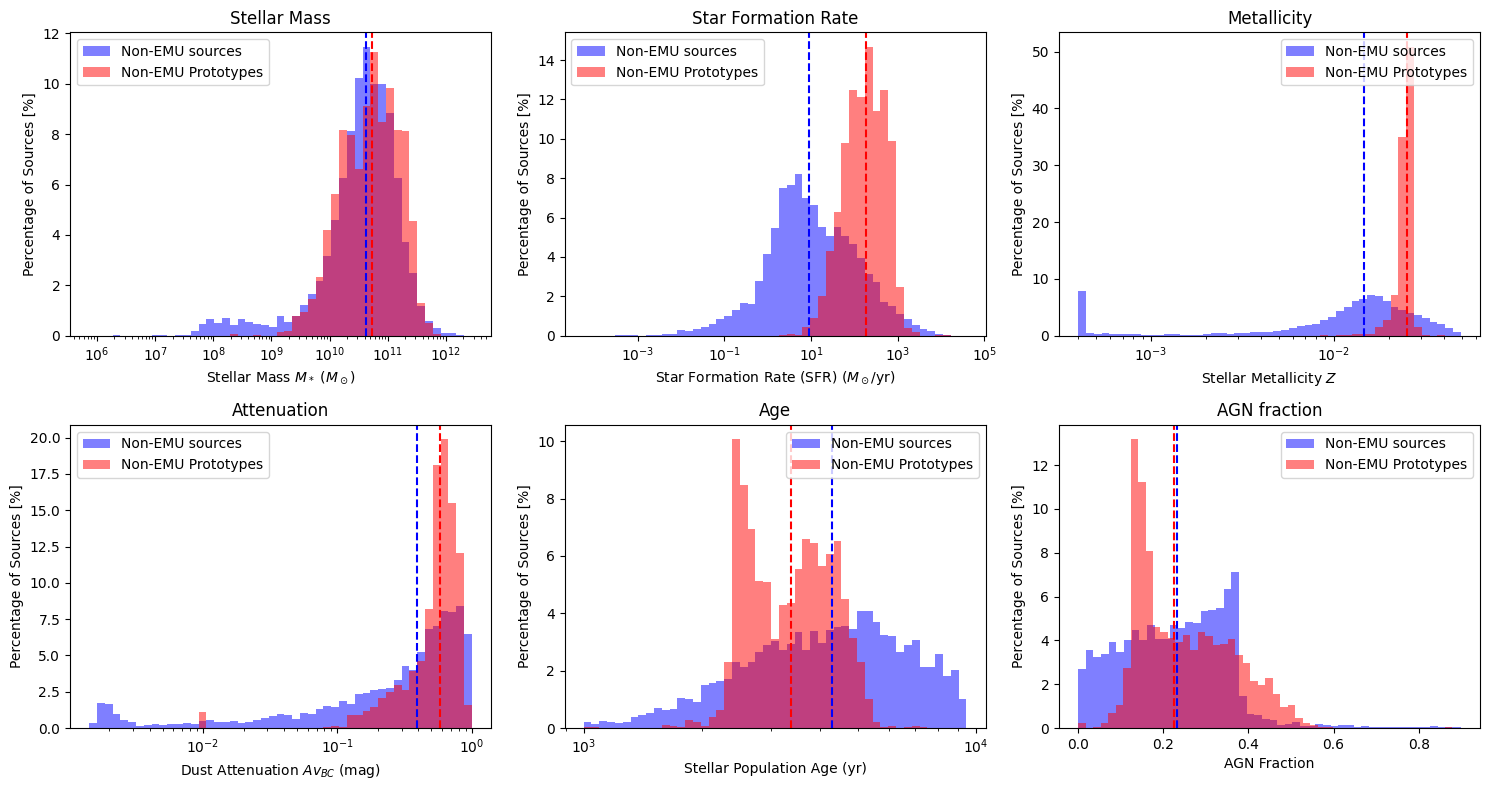

In [61]:
plot_log_hist_percent_2rows_sns(
    df1=nonemu_sources_best,
    df2=nonemu_prototypes_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $Av_{BC}$ (mag)",
        r"Stellar Population Age (yr)",
        r"AGN Fraction"
    ],
    labels=("Non-EMU sources", "Non-EMU Prototypes"),
    legend_positions= ['upper left', 'upper left','upper right','upper left','upper right','upper right' ],
    titles = ['Stellar Mass', 'Star Formation Rate', 'Metallicity', 'Attenuation', 'Age', 'AGN fraction']
)

### Density plot of EMU and non-EMU sources

In [62]:
def plot_log_kde_2rows_sns(df1, df2, columns, x_labels, legend_positions, labels=("DF1", "DF2"), figsize=(15, 8)):
    """
    Plot KDE (density) curves using Seaborn for specified columns from two DataFrames in 2 rows.
    Uses log scaling on axes where appropriate.

    Parameters:
    - df1, df2: pandas DataFrames
    - columns: list of column names to plot (must exist in both)
    - x_labels: list of x-axis labels (same length as columns)
    - labels: tuple of legend labels for df1 and df2
    - figsize: tuple for figure size
    """
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]
        
        data1 = df1[col].dropna()
        data2 = df2[col].dropna()

        if 'bayes.agn.fracAGN' in col:
            # Linear scale
            sns.kdeplot(data1, ax=ax, label=labels[0], color='blue', fill=True, common_norm=False)
            sns.kdeplot(data2, ax=ax, label=labels[1], color='red', fill=True, common_norm=False)
        else:
            # Log scale (filter > 0)
            data1 = data1[data1 > 0]
            data2 = data2[data2 > 0]
            sns.kdeplot(np.log10(data1), ax=ax, label=labels[0], color='blue', fill=True, common_norm=False)
            sns.kdeplot(np.log10(data2), ax=ax, label=labels[1], color='red', fill=True, common_norm=False)
            ax.set_xlabel(x_labels[i] + " (log₁₀)")
            ax.set_xticks(np.arange(np.floor(np.log10(data1.min())), np.ceil(np.log10(data1.max())) + 1))
            ax.set_xticklabels([f"$10^{int(x)}$" for x in ax.get_xticks()])
            ax.set_xlim(left=np.log10(min(data1.min(), data2.min())))

        ax.set_title(col)
        ax.set_ylabel('Density')
        ax.legend(loc = legend_positions[i])

    # Hide unused subplots
    for j in range(n, nrows * ncols):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

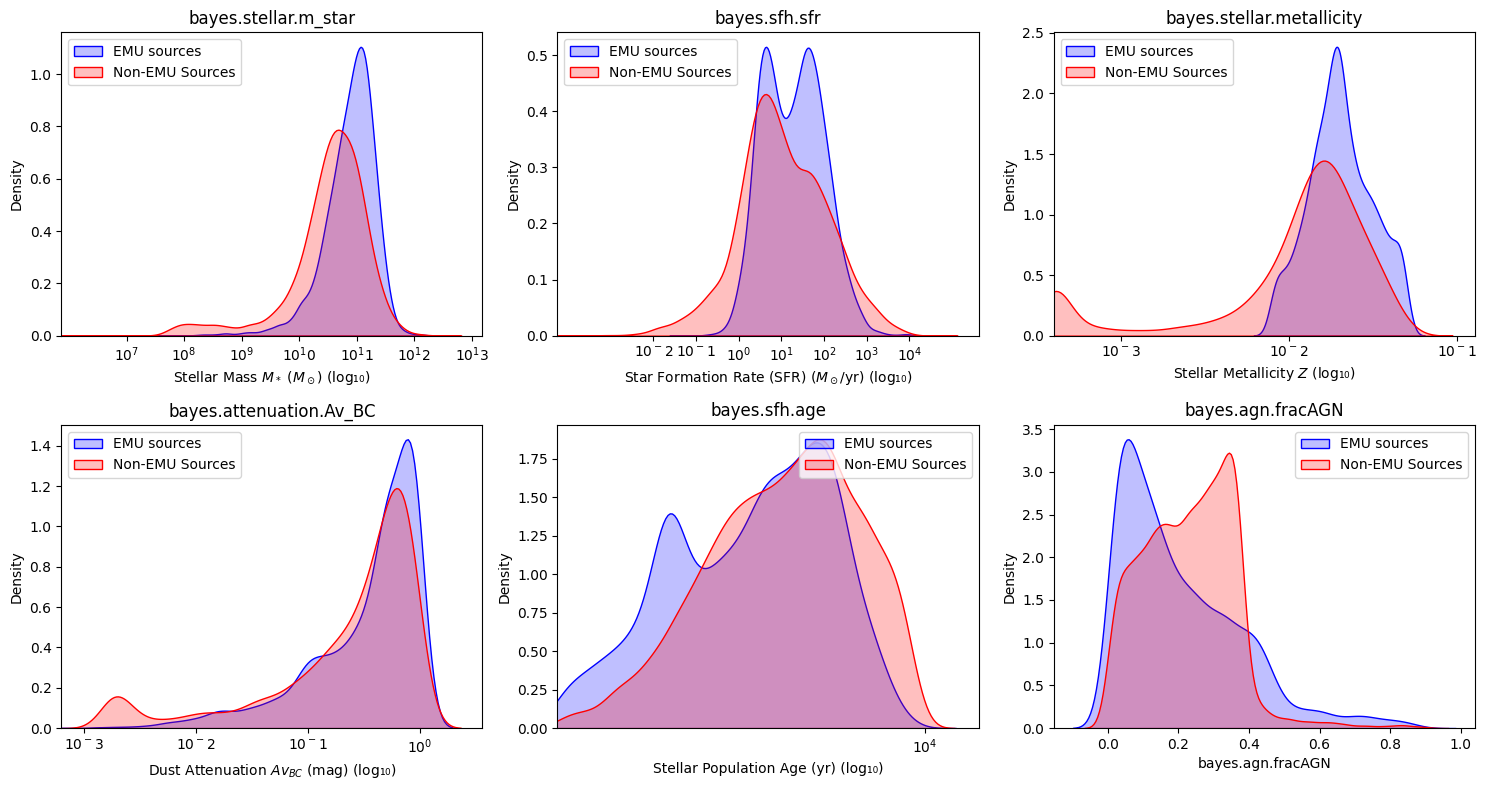

In [65]:
plot_log_kde_2rows_sns(
    df1=emu_sources_best,
    df2=nonemu_sources_best,
    columns=[
        'bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity',
        'bayes.attenuation.Av_BC', 'bayes.sfh.age', 'bayes.agn.fracAGN'
    ],
    x_labels=[
        r"Stellar Mass $M_*$ ($M_\odot$)",
        r"Star Formation Rate (SFR) ($M_\odot$/yr)",
        r"Stellar Metallicity $Z$",
        r"Dust Attenuation $Av_{BC}$ (mag)",
        r"Stellar Population Age (yr)",
        r"AGN Fraction",
    ],
    labels=("EMU sources", "Non-EMU Sources"),
    legend_positions= ['upper left', 'upper left','upper left','upper left','upper right','upper right' ]
)